In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[3]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']



symbols_short = symbols['Ticker_Symbol']
symbols_short

0     BDEV.L
1      EDV.L
3     ABDN.L
4     BLND.L
6     JMAT.L
7      HSX.L
8      UTG.L
9     FRAS.L
10     CCL.L
11    INVP.L
12     ICP.L
13     IMI.L
14    HWDN.L
15     HIK.L
16    INCH.L
18     EZJ.L
19     DPH.L
20     ITV.L
21    DPLM.L
22     IGG.L
23     SXS.L
24    TATE.L
25     EMG.L
26     TUI.L
27     GAW.L
28     MKS.L
29     DLN.L
30     RSW.L
31    BBOX.L
32     ROR.L
33     GRG.L
34     VTY.L
Name: Ticker_Symbol, dtype: object

In [5]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [6]:
data = price_volume_data(symbols_short.to_list(),'2018-02-22', '2023-02-28')
data.pv

{'BDEV.L':                                  Open        High         Low       Close  \
 Date                                                                        
 2018-02-22 00:00:00+00:00  399.844871  402.394386  388.088910  390.780029   
 2018-02-23 00:00:00+00:00  391.771533  392.904622  386.247648  389.080414   
 2018-02-26 00:00:00+00:00  389.930162  393.187868  388.088881  390.355103   
 2018-02-27 00:00:00+00:00  396.587226  402.536052  386.814192  388.088928   
 2018-02-28 00:00:00+00:00  383.414887  387.947286  379.448989  381.715210   
 ...                               ...         ...         ...         ...   
 2023-02-21 00:00:00+00:00  435.043703  435.377910  419.818108  421.210693   
 2023-02-22 00:00:00+00:00  420.375079  425.295565  417.116449  422.881744   
 2023-02-23 00:00:00+00:00  422.139057  427.338019  421.860523  424.367188   
 2023-02-24 00:00:00+00:00  427.152339  428.916275  420.282257  420.282257   
 2023-02-27 00:00:00+00:00  424.274350  430.680237  42

In [7]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [8]:
df

Ticker_Symbol,BDEV.L,EDV.L,ABDN.L,BLND.L,JMAT.L,HSX.L,UTG.L,FRAS.L,CCL.L,INVP.L,...,EMG.L,TUI.L,GAW.L,MKS.L,DLN.L,RSW.L,BBOX.L,ROR.L,GRG.L,VTY.L
2018-02-22,390.780029,1963.699097,279.891296,490.609711,2687.480957,1198.746826,656.953491,376.600006,4409.069336,348.313538,...,135.787796,13935.264648,1887.507080,251.491806,2424.250977,4612.427246,108.344444,253.206253,1103.772583,771.595032
2018-02-23,389.080414,1963.699097,272.924866,500.301910,2666.386230,1203.921265,659.920410,374.000000,4370.801270,351.189392,...,130.401428,13944.284180,1941.199829,253.012985,2444.679932,4532.162109,108.881569,253.119003,1106.312012,769.455627
2018-02-26,390.355103,1963.699097,269.223969,500.148071,2659.635986,1178.911499,668.820984,374.100006,4399.958984,348.866516,...,130.073868,13795.461914,1982.502075,253.773514,2476.174805,4550.829590,109.802315,255.824768,1110.544312,766.246643
2018-02-27,388.088928,1963.699097,271.400879,490.148163,2662.167480,1196.159546,655.681946,370.200012,4392.669434,352.184937,...,131.784439,14007.421875,1990.762451,253.520004,2525.545166,4571.362305,108.958267,257.919525,1093.615112,765.533508
2018-02-28,381.715210,1963.699097,267.119476,483.071320,2645.291504,1199.609131,645.509766,367.399994,4372.624023,351.189392,...,125.015083,13930.754883,1974.241455,249.801697,2445.531250,4511.629883,107.807327,257.483124,1011.509460,749.131714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,421.210693,1692.330444,193.502747,424.567688,2096.798096,1097.981445,935.380066,804.000000,824.200012,509.219421,...,240.065155,1722.000000,8950.904297,152.550003,2489.256348,3862.539551,144.186630,316.037628,2650.445068,756.376709
2023-02-22,422.881744,1662.790771,192.393311,422.151520,2114.247070,1091.161743,932.484131,794.500000,821.400024,509.989197,...,235.914734,1668.000000,8912.091797,150.500000,2458.381592,3800.786621,142.742828,316.428772,2642.620850,748.683167
2023-02-23,424.367188,1648.153564,194.057449,424.084473,2101.645020,1088.726074,936.345398,784.500000,810.400024,515.955139,...,236.858017,1633.000000,8965.458984,152.750000,2473.818848,3872.499756,145.245392,320.340118,2628.928467,765.993713
2023-02-24,420.282257,1654.984253,195.074432,422.538147,2084.195801,1097.494385,935.862732,795.000000,789.000000,498.634735,...,230.915344,1542.599976,8907.241211,152.899994,2471.889160,3958.156738,143.897858,319.753418,2609.367920,770.321411


In [9]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [10]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [11]:
########################################

In [12]:
df_standardised = df.iloc[:-7].apply(lambda price: (price.iloc[:-7] - price.iloc[:-7].mean())/price.iloc[:-7].std())
df_standardised




Ticker_Symbol,BDEV.L,EDV.L,ABDN.L,BLND.L,JMAT.L,HSX.L,UTG.L,FRAS.L,CCL.L,INVP.L,...,EMG.L,TUI.L,GAW.L,MKS.L,DLN.L,RSW.L,BBOX.L,ROR.L,GRG.L,VTY.L
2018-02-22,-0.829682,-0.157080,2.118753,0.795863,0.633026,0.502094,-1.852892,-0.511224,1.608451,0.693657,...,-0.307151,1.861462,-1.545440,1.312382,-1.141561,0.351267,-1.026146,-0.853940,-1.232652,-0.311474
2018-02-23,-0.848799,-0.157080,1.922936,0.952353,0.584237,0.521231,-1.831396,-0.525147,1.580025,0.723239,...,-0.432201,1.863570,-1.525908,1.339658,-1.085126,0.248738,-1.011116,-0.856343,-1.228108,-0.323840
2018-02-26,-0.834462,-0.157080,1.818909,0.949869,0.568624,0.428736,-1.766909,-0.524612,1.601684,0.699345,...,-0.439806,1.828801,-1.510883,1.353295,-0.998121,0.272583,-0.985352,-0.781807,-1.220536,-0.342388
2018-02-27,-0.859951,-0.157080,1.880099,0.788411,0.574479,0.492525,-1.862105,-0.545496,1.596269,0.733479,...,-0.400093,1.878320,-1.507879,1.348749,-0.861734,0.298811,-1.008970,-0.724103,-1.250826,-0.346510
2018-02-28,-0.931641,-0.157080,1.759754,0.674149,0.535447,0.505283,-1.935804,-0.560490,1.581379,0.723239,...,-0.557252,1.860409,-1.513888,1.282076,-1.082774,0.222510,-1.041175,-0.736124,-1.397734,-0.441313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,-0.382983,-0.505468,-0.340702,-0.156531,-0.432711,0.082590,0.360195,1.667706,-1.092525,2.309185,...,2.008651,-0.995730,1.029338,-0.505678,-0.924668,-0.614259,0.114436,0.844556,1.517239,-0.593990
2023-02-02,-0.169960,-0.419825,-0.073034,0.230458,-0.295943,0.116820,0.751849,1.774805,-1.013933,2.425980,...,2.240784,-0.968746,1.110521,-0.309333,-0.572841,-0.283464,0.437638,1.167795,1.727231,-0.368864
2023-02-03,-0.289002,-0.436536,-0.117212,0.160239,-0.262312,0.113217,0.632954,1.772127,-1.005614,2.459633,...,2.278013,-0.969330,1.126404,-0.274367,-0.690116,-0.405604,0.280043,1.232443,1.695732,-0.449464
2023-02-06,-0.357921,-0.426092,-0.228957,-0.011411,-0.322849,0.115018,0.542034,1.721255,-1.018390,2.307205,...,2.216695,-0.966877,1.069929,-0.353264,-0.738093,-0.471763,0.210595,1.167795,1.646734,-0.491154


In [13]:
# actual_price_ls = []
# for column in df.columns:
#     actual_price_ls.append((df[column].iloc[-1] - df[column].mean()) / df[column].std())
# actual_price_df = pd.DataFrame(index = df.columns)
# actual_price_df["actual_price"] = actual_price_ls

# actual_price_df

actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-7].mean()
    ticker_std_dict[column] = df[column].iloc[:-7].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls

actual_price_df

,actual_price
Ticker_Symbol,
BDEV.L,-0.379875
EDV.L,-0.825824
ABDN.L,-0.202352
BLND.L,-0.161147
JMAT.L,-0.716008
HSX.L,0.190444
UTG.L,0.274519
FRAS.L,1.757952
CCL.L,-1.055180


In [14]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    #.iloc[:-7]
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


#import the price data for the remaining target universe at different rank dates

#dictionary to store DataFrames
dfs_target_uni = {}
params_dict_ = {}

# Loop through each sheet name and read the corresponding sheet into a DataFrame
for date in sheet_name:
    dfs_target_uni[f'df_{sheet_name}'] = pd.read_excel("target_stock_universe.xlsx", sheet_name=date)
    
    params_dict_[date] = get_ARIMA_PRED(df_standardised, 3)
    

sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1754.145, Time=5.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1753.270, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1753.148, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1756.120, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1753.089, Time=1.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.665 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 BDEV.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 879.060
Date:                Sat, 21 Oct 2023   AIC                          -1756.120
Time:                        14:15:16   BIC                          -1750.991
Sample:                             0   HQIC                         -1754.192
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0143      0.000     51.204      0.000       0.014       0.015
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):              2131.63
Prob(Q):                              0.29   Pr

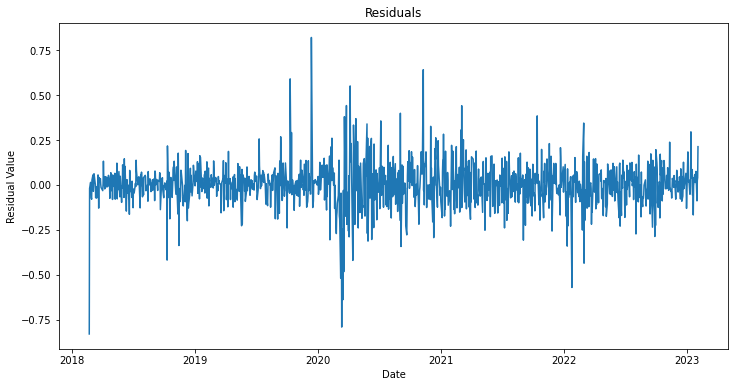

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1313.071, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1313.469, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1313.636, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1315.068, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1319.264, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1317.575, Time=2.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1317.537, Time=1.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1313.235, Time=0.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1312.594, Time=1.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1316.048, Time=3.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1321.259, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1315.633, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1315.466, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1319.570, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

                               SARIMAX Results                                
Dep. Variable:                  EDV.L   No. Observations:                 1249
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 663.629
Date:                Sat, 21 Oct 2023   AIC                          -1321.259
Time:                        14:15:34   BIC                          -1305.871
Sample:                             0   HQIC                         -1315.473
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7469      0.115      6.497      0.000       0.522       0.972
ma.L1         -0.8071      0.103     -7.809      0.000      -1.010      -0.605
sigma2         0.0202      0.000    159.734      0.0

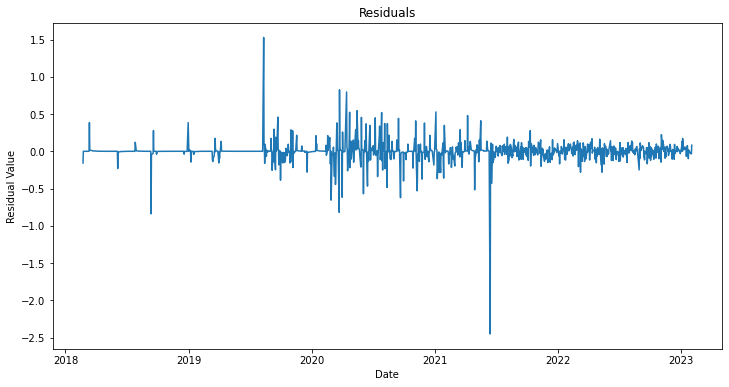

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1706.699, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1705.600, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1705.544, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1708.440, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1704.521, Time=2.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.966 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                 ABDN.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 855.220
Date:                Sat, 21 Oct 2023   AIC                          -1708.440
Time:                        14:15:39   BIC                          -1703.311
Sample:                             0   HQIC                         -1706.512
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0149      0.000     45.275      0.000       0.014       0.016
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1101.89
Prob(Q):                              0.34   Pr

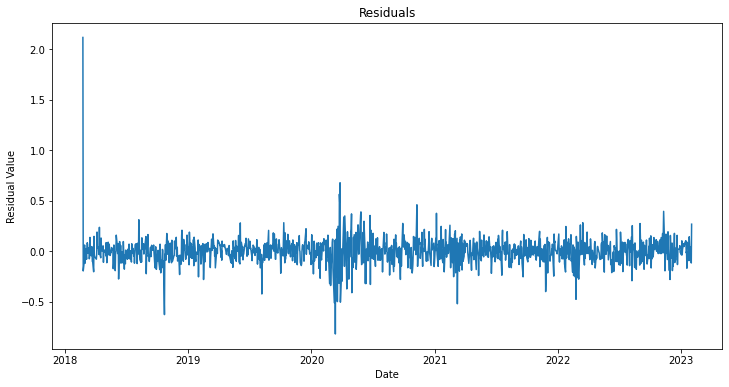

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1499.893, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1497.984, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1497.980, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1501.878, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1495.982, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.524 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 BLND.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 751.939
Date:                Sat, 21 Oct 2023   AIC                          -1501.878
Time:                        14:15:41   BIC                          -1496.749
Sample:                             0   HQIC                         -1499.950
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0175      0.000     52.177      0.000       0.017       0.018
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2374.51
Prob(Q):                              0.76   Pr

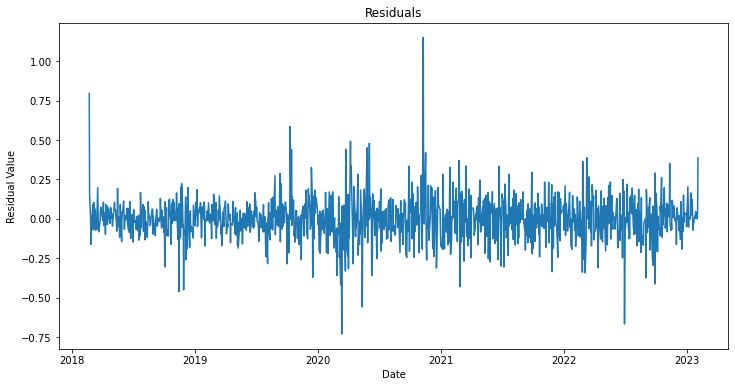

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1904.584, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1903.562, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1903.614, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1906.529, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1902.580, Time=1.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.585 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1244
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 954.264
Date:                Sat, 21 Oct 2023   AIC                          -1906.529
Time:                        14:15:45   BIC                          -1901.404
Sample:                             0   HQIC                         -1904.602
                               - 1244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0126      0.000     64.664      0.000       0.012       0.013
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):              6857.81
Prob(Q):                              0.32   Pr

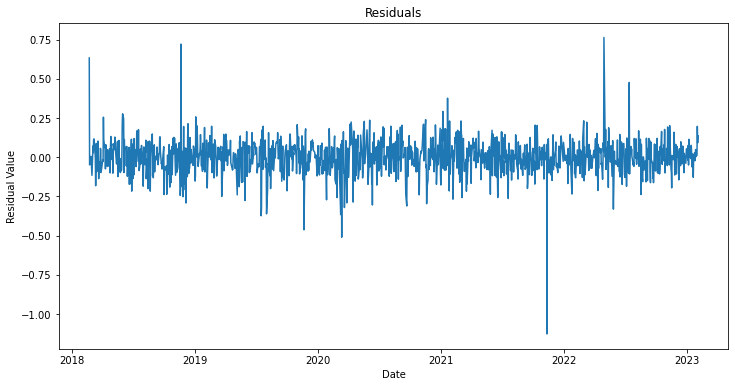

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2902.106, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2901.865, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2902.094, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2904.085, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2902.517, Time=0.82 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.411 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1453.042
Date:                Sat, 21 Oct 2023   AIC                          -2904.085
Time:                        14:15:48   BIC                          -2898.955
Sample:                             0   HQIC                         -2902.156
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0057      7e-05     81.531      0.000       0.006       0.006
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):             19494.85
Prob(Q):                              0.18   Pr

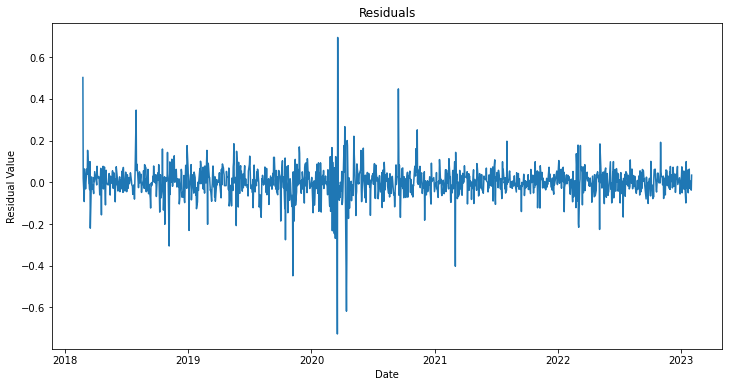

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1664.218, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1671.492, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1670.737, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1665.864, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1671.210, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1670.270, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1670.328, Time=2.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1673.186, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1672.921, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1671.975, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1672.424, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1672.037, Time=1.43 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 7.688 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  UTG.L   No. Observations:                 1249
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 838.593
Date:                Sat, 21 Oct 2023   AIC                          -1673.186
Time:                        14:15:57   BIC                          -1662.927
Sample:                             0   HQIC                         -1669.329
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0866      0.019      4.567      0.000       0.049       0.124
sigma2         0.0153      0.000     47.350      0.000       0.015       0.016
Ljung-Box (L1) (Q):                   0.01   Jarque-

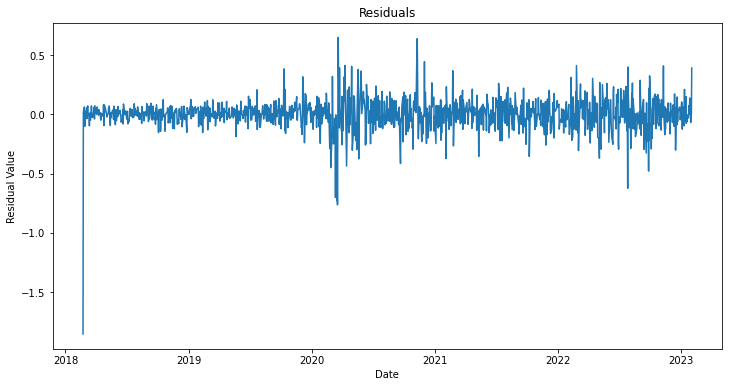

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3098.463, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3098.009, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3097.944, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3099.604, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3096.707, Time=0.69 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.285 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 FRAS.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1550.802
Date:                Sat, 21 Oct 2023   AIC                          -3099.604
Time:                        14:16:00   BIC                          -3094.474
Sample:                             0   HQIC                         -3097.675
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0049   3.81e-05    127.883      0.000       0.005       0.005
Ljung-Box (L1) (Q):                   1.55   Jarque-Bera (JB):            132624.80
Prob(Q):                              0.21   Pr

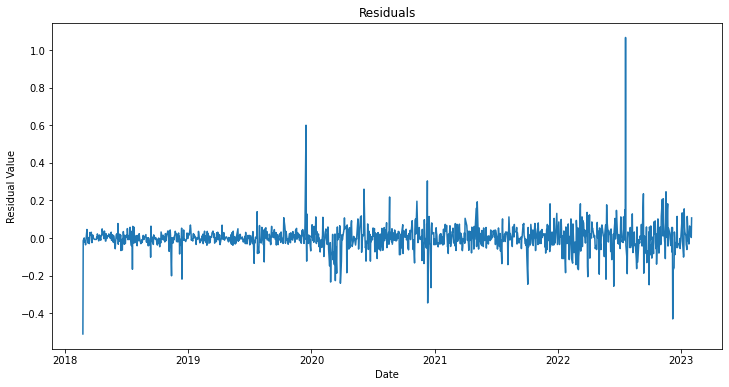

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3895.735, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3895.142, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3895.016, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3895.595, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3892.875, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.948 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  CCL.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1948.797
Date:                Sat, 21 Oct 2023   AIC                          -3895.595
Time:                        14:16:03   BIC                          -3890.466
Sample:                             0   HQIC                         -3893.666
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0026   2.69e-05     95.665      0.000       0.003       0.003
Ljung-Box (L1) (Q):                   1.41   Jarque-Bera (JB):             38818.37
Prob(Q):                              0.24   Pr

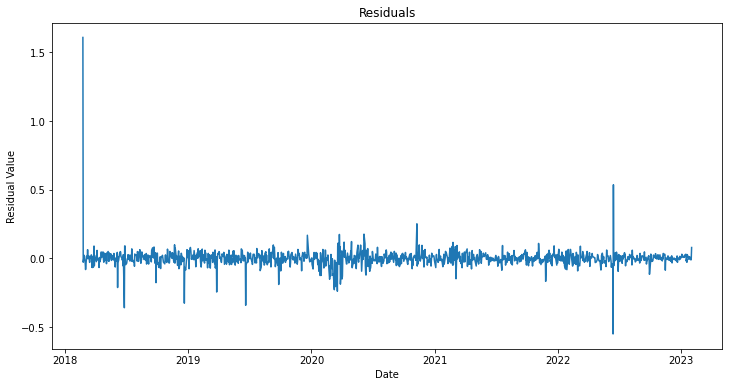

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3271.584, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3269.813, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3269.779, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3273.017, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3267.598, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.125 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 INVP.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1637.509
Date:                Sat, 21 Oct 2023   AIC                          -3273.017
Time:                        14:16:06   BIC                          -3267.888
Sample:                             0   HQIC                         -3271.089
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0042   8.39e-05     50.593      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              2196.31
Prob(Q):                              0.63   Pr

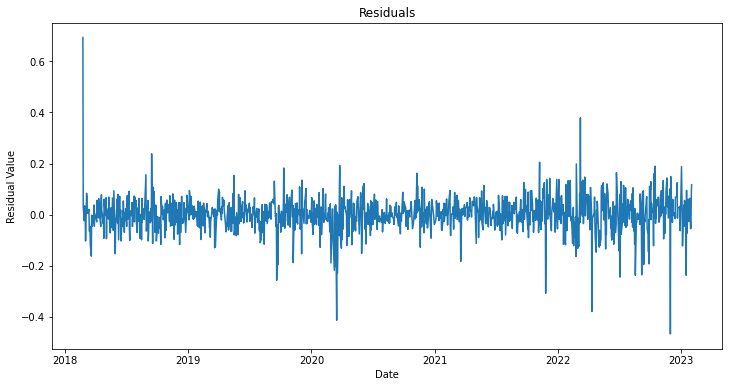

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2618.521, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2616.730, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2616.707, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2620.238, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2617.261, Time=1.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.525 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1311.119
Date:                Sat, 21 Oct 2023   AIC                          -2620.238
Time:                        14:16:10   BIC                          -2615.109
Sample:                             0   HQIC                         -2618.310
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0072      0.000     48.371      0.000       0.007       0.007
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              1691.82
Prob(Q):                              0.65   Pr

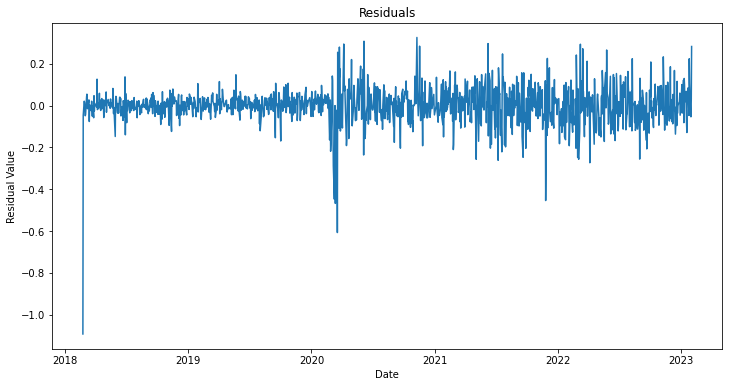

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2969.380, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2967.682, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2967.679, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2970.976, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2965.658, Time=0.90 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.935 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1486.488
Date:                Sat, 21 Oct 2023   AIC                          -2970.976
Time:                        14:16:12   BIC                          -2965.847
Sample:                             0   HQIC                         -2969.047
                               - 1249                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


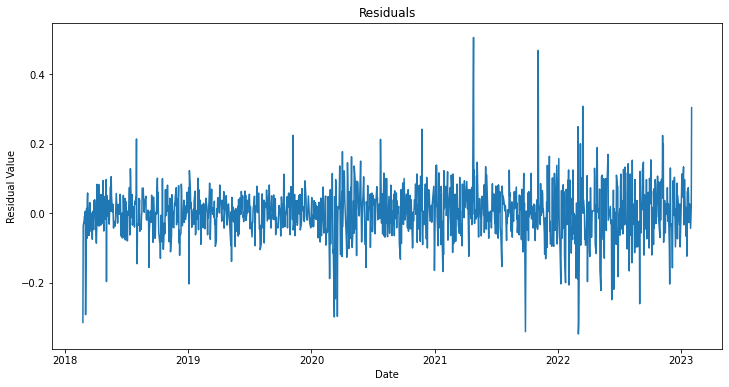

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2813.673, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2815.203, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2814.840, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2815.023, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2816.857, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2816.670, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2815.492, Time=1.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2814.417, Time=2.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2816.671, Time=4.33 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2818.319, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2816.612, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2818.095, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2816.947, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2815.856, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1249
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1412.160
Date:                Sat, 21 Oct 2023   AIC                          -2818.319
Time:                        14:16:28   BIC                          -2802.931
Sample:                             0   HQIC                         -2812.534
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0510      0.021      2.389      0.017       0.009       0.093
ar.L2          0.0548      0.021      2.659      0.008       0.014       0.095
sigma2         0.0061      0.000     36.493      0.0

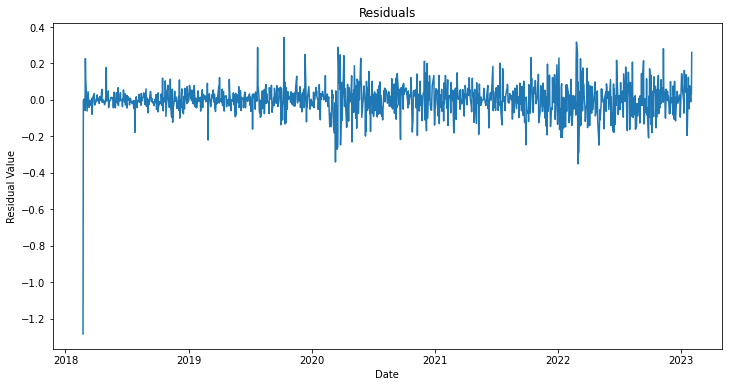

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2457.792, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2457.414, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2457.499, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2459.327, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2455.951, Time=1.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.562 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1248
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1230.663
Date:                Sat, 21 Oct 2023   AIC                          -2459.327
Time:                        14:16:32   BIC                          -2454.198
Sample:                             0   HQIC                         -2457.398
                               - 1248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0081      0.000     43.551      0.000       0.008       0.008
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):               873.66
Prob(Q):                              0.20   Pr

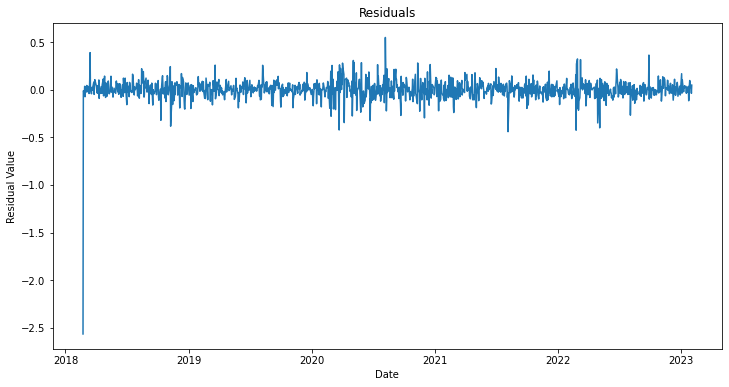

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-272.140, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-482.719, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-549.904, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-274.031, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-548.499, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-548.460, Time=1.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-546.664, Time=2.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-551.341, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-549.908, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-549.872, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-484.471, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-548.059, Time=2.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 10.168 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 INCH.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 277.671
Date:                Sat, 21 Oct 2023   AIC                           -551.341
Time:                        14:16:44   BIC                           -541.083
Sample:                             0   HQIC                          -547.484
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5116      0.003   -175.637      0.000      -0.517      -0.506
sigma2         0.0375      0.000    349.318      0.000       0.037       0.038
Ljung-Box (L1) (Q):                   0.12   Jarque-

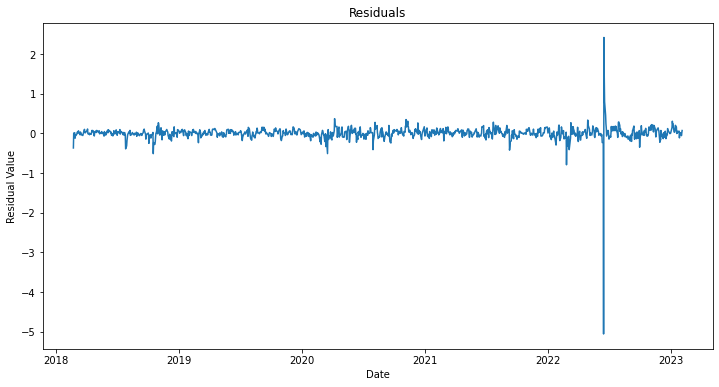

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2913.237, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2915.308, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2914.851, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2914.113, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2917.964, Time=0.92 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2916.318, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2916.148, Time=1.95 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2915.490, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2914.639, Time=3.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2919.074, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2916.303, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2917.398, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2917.245, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2916.593, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EZJ.L   No. Observations:                 1248
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1462.537
Date:                Sat, 21 Oct 2023   AIC                          -2919.074
Time:                        14:16:57   BIC                          -2903.688
Sample:                             0   HQIC                         -2913.289
                               - 1248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0543      0.026      2.099      0.036       0.004       0.105
ar.L2          0.0619      0.020      3.120      0.002       0.023       0.101
sigma2         0.0056   9.86e-05     56.866      0.0

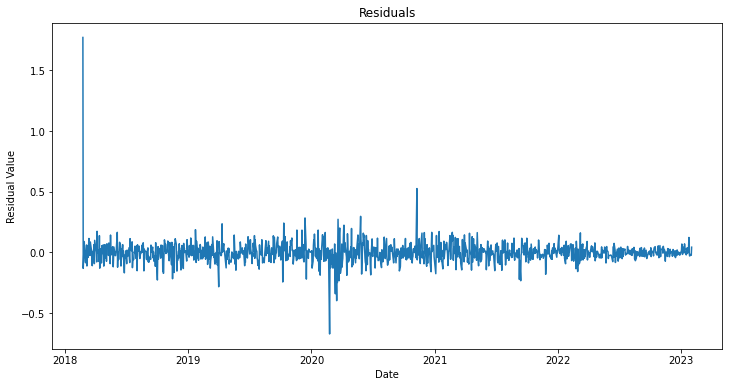

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-750.656, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-963.911, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1007.899, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-752.625, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1005.969, Time=2.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1005.961, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1004.174, Time=1.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1009.792, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1007.864, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1007.855, Time=0.92 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-965.846, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1006.069, Time=0.56 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 9.454 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  DPH.L   No. Observations:                 1240
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 506.896
Date:                Sat, 21 Oct 2023   AIC                          -1009.792
Time:                        14:17:07   BIC                           -999.548
Sample:                             0   HQIC                         -1005.939
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4793      0.003   -164.714      0.000      -0.485      -0.474
sigma2         0.0258    7.8e-05    330.981      0.000       0.026       0.026
Ljung-Box (L1) (Q):                   0.02   Jarque-

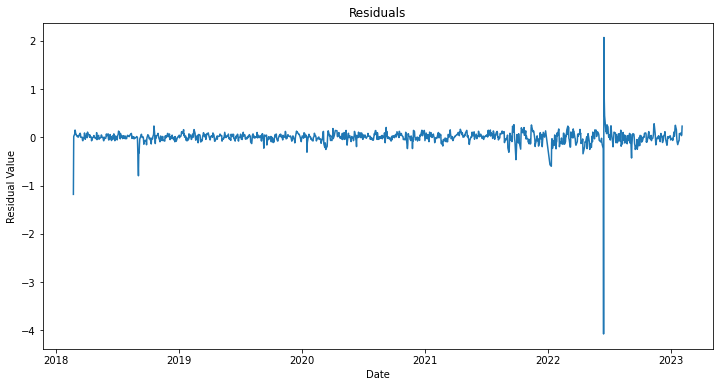

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2196.106, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2194.106, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2194.106, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2197.822, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2193.914, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.547 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  ITV.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1099.911
Date:                Sat, 21 Oct 2023   AIC                          -2197.822
Time:                        14:17:11   BIC                          -2192.693
Sample:                             0   HQIC                         -2195.894
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0100      0.000     82.997      0.000       0.010       0.010
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21184.78
Prob(Q):                              0.99   Pr

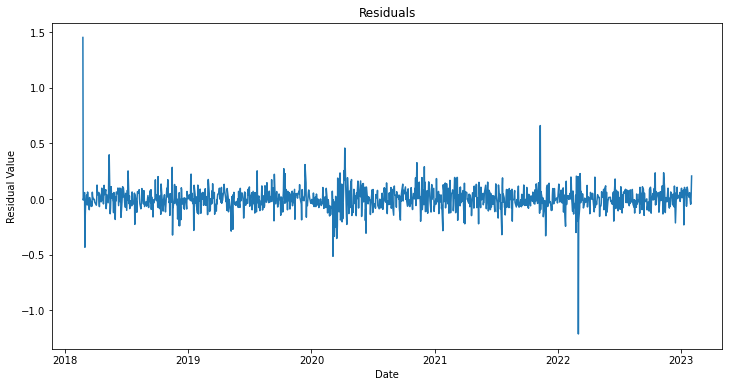

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3267.211, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3265.974, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3265.954, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3267.658, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3263.974, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.333 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1634.829
Date:                Sat, 21 Oct 2023   AIC                          -3267.658
Time:                        14:17:15   BIC                          -3262.528
Sample:                             0   HQIC                         -3265.729
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0043   5.97e-05     71.444      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):             10745.90
Prob(Q):                              0.39   Pr

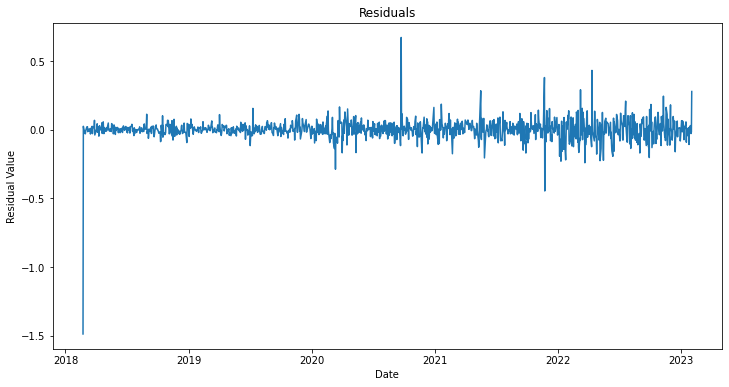

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2600.900, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2604.005, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2604.066, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2602.498, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2602.121, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2602.105, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2602.234, Time=2.95 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2605.608, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2603.654, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2603.641, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2605.550, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2603.767, Time=1.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.480 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  IGG.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1304.804
Date:                Sat, 21 Oct 2023   AIC                          -2605.608
Time:                        14:17:23   BIC                          -2595.349
Sample:                             0   HQIC                         -2601.751
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0642      0.020     -3.203      0.001      -0.103      -0.025
sigma2         0.0072      0.000     59.478      0.000       0.007       0.007
Ljung-Box (L1) (Q):                   0.00   Jarque-

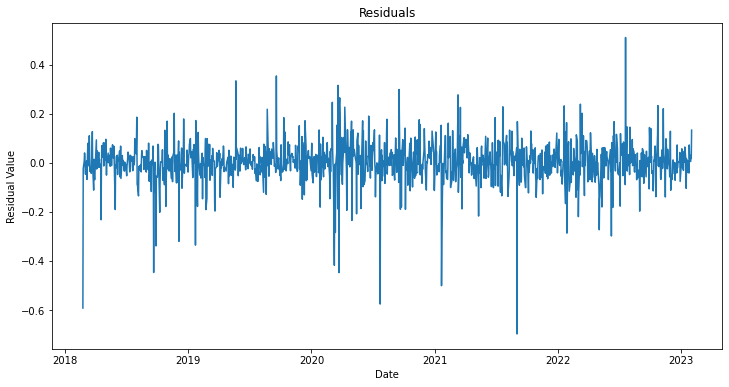

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2430.544, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2434.588, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2434.429, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2432.184, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2432.777, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2432.891, Time=1.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2430.759, Time=1.65 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2436.178, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2434.376, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2434.484, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2436.017, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2432.358, Time=0.50 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.213 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SXS.L   No. Observations:                 1249
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1220.089
Date:                Sat, 21 Oct 2023   AIC                          -2436.178
Time:                        14:17:31   BIC                          -2425.920
Sample:                             0   HQIC                         -2432.321
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0694      0.024     -2.914      0.004      -0.116      -0.023
sigma2         0.0083      0.000     39.449      0.000       0.008       0.009
Ljung-Box (L1) (Q):                   0.00   Jarque-

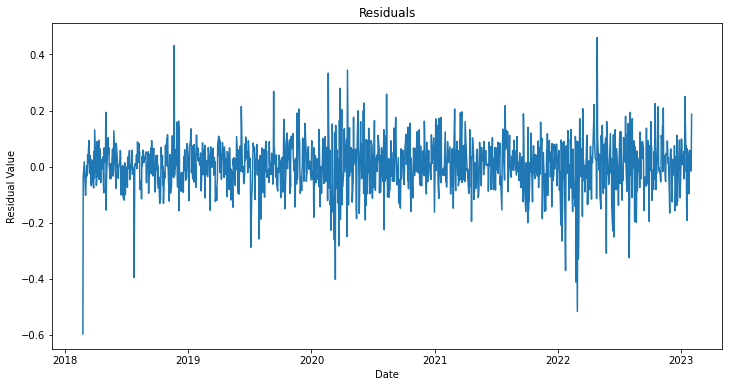

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1597.216, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1598.366, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1598.225, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1598.411, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1596.815, Time=1.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.518 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 TATE.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 800.205
Date:                Sat, 21 Oct 2023   AIC                          -1598.411
Time:                        14:17:34   BIC                          -1593.281
Sample:                             0   HQIC                         -1596.482
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0162      0.000     46.125      0.000       0.016       0.017
Ljung-Box (L1) (Q):                   3.14   Jarque-Bera (JB):              1207.20
Prob(Q):                              0.08   Pr

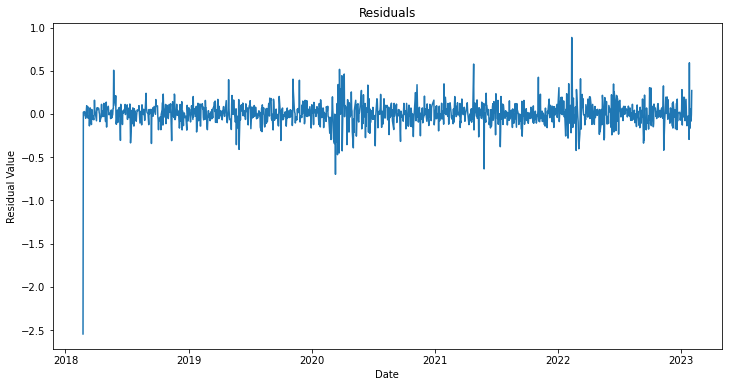

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3102.219, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3104.286, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3104.159, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3103.149, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3102.498, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3102.386, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3100.522, Time=1.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3105.092, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3103.335, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3103.196, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3104.963, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3101.361, Time=0.46 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.945 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EMG.L   No. Observations:                 1249
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1554.546
Date:                Sat, 21 Oct 2023   AIC                          -3105.092
Time:                        14:17:41   BIC                          -3094.833
Sample:                             0   HQIC                         -3101.235
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0564      0.019     -2.956      0.003      -0.094      -0.019
sigma2         0.0048      0.000     45.167      0.000       0.005       0.005
Ljung-Box (L1) (Q):                   0.00   Jarque-

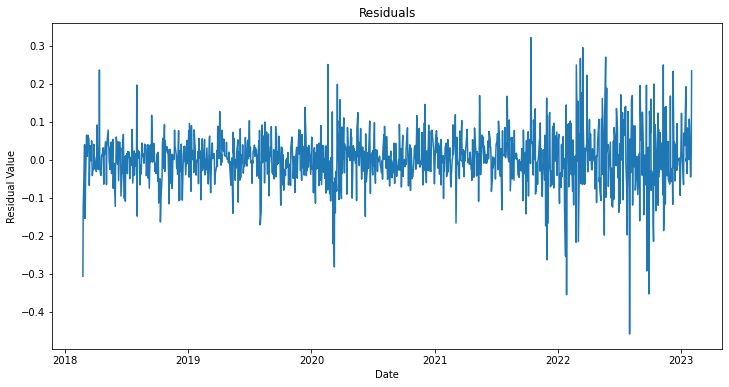

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4273.563, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4276.453, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4276.563, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4272.191, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4274.710, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4274.678, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4272.670, Time=1.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4275.583, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.299 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  TUI.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2139.791
Date:                Sat, 21 Oct 2023   AIC                          -4275.583
Time:                        14:17:46   BIC                          -4265.324
Sample:                             0   HQIC                         -4271.726
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0667      0.020      3.370      0.001       0.028       0.106
sigma2         0.0019   2.46e-05     77.063      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.01   Jarque-

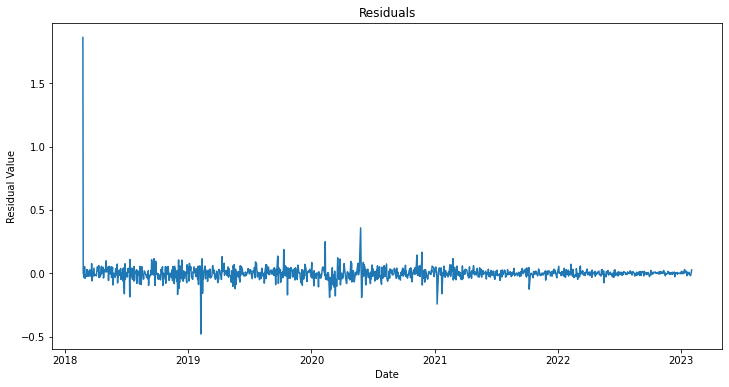

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2142.217, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2311.312, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2333.797, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2143.677, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2332.272, Time=1.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2332.264, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2330.276, Time=2.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2334.084, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2332.621, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2332.615, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2312.192, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2330.220, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.873 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


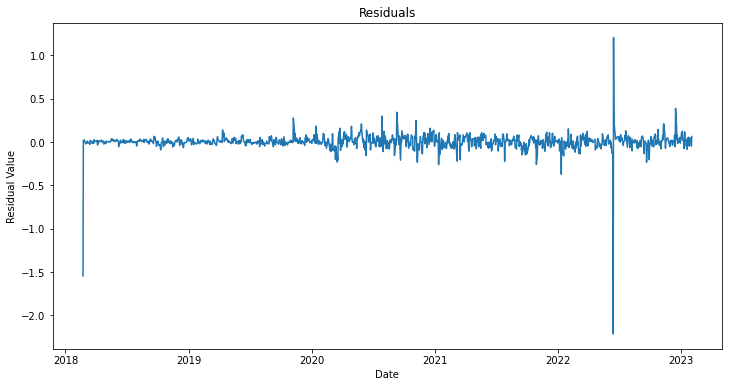

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2849.908, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2850.052, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2850.111, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2851.554, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2848.141, Time=1.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.000 seconds
                               SARIMAX Results                                
Dep. Variable:                  MKS.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1426.777
Date:                Sat, 21 Oct 2023   AIC                          -2851.554
Time:                        14:17:57   BIC                          -2846.425
Sample:                             0   HQIC                         -2849.626
                               - 1249                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


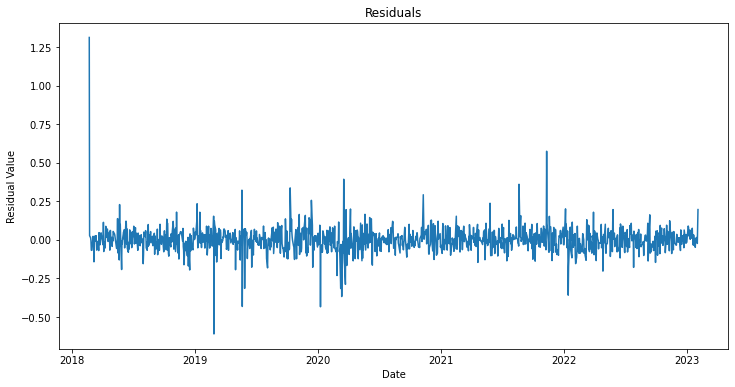

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1509.974, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1508.130, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1508.109, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1511.959, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1507.820, Time=1.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.197 seconds
                               SARIMAX Results                                
Dep. Variable:                  DLN.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 756.980
Date:                Sat, 21 Oct 2023   AIC                          -1511.959
Time:                        14:18:00   BIC                          -1506.830
Sample:                             0   HQIC                         -1510.031
                               - 1249                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


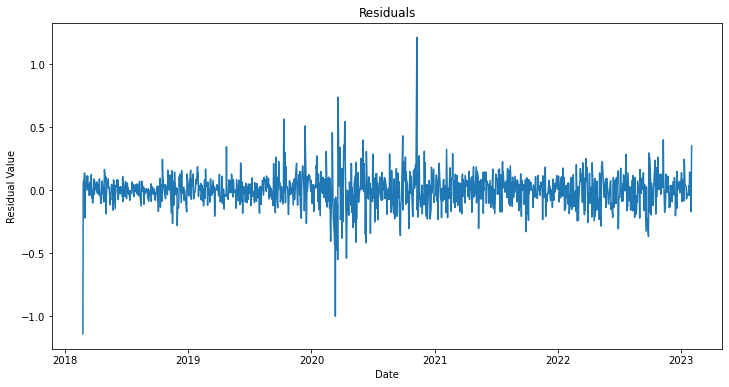

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1489.268, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1487.631, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1487.657, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1491.249, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1489.175, Time=0.79 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.848 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  RSW.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 746.625
Date:                Sat, 21 Oct 2023   AIC                          -1491.249
Time:                        14:18:03   BIC                          -1486.120
Sample:                             0   HQIC                         -1489.321
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0177      0.000     64.856      0.000       0.017       0.018
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              6972.48
Prob(Q):                              0.55   Pr

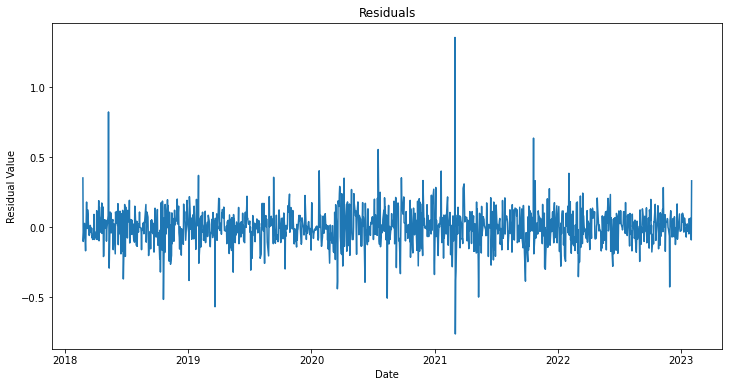

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-459.414, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-700.280, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-796.697, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-461.372, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-795.944, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-795.816, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-793.005, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-798.462, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-797.691, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-797.565, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-702.190, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-794.766, Time=0.37 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.222 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


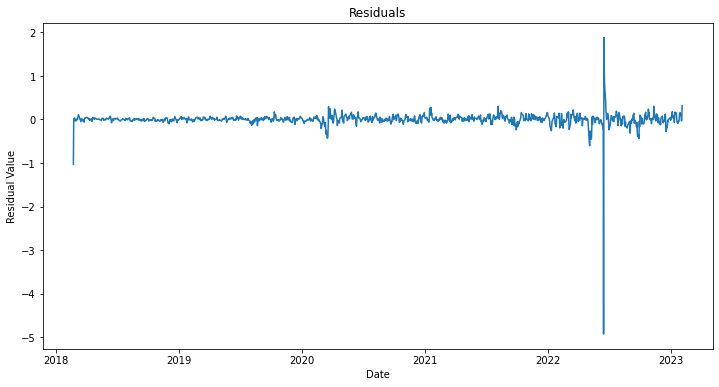

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=615.552, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=421.739, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=370.489, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=613.586, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=370.915, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=371.221, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=371.507, Time=1.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=368.618, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=369.057, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=369.359, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=419.809, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=369.662, Time=0.67 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.098 seconds
                               SARIMAX Results                                
Dep. Variable:       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


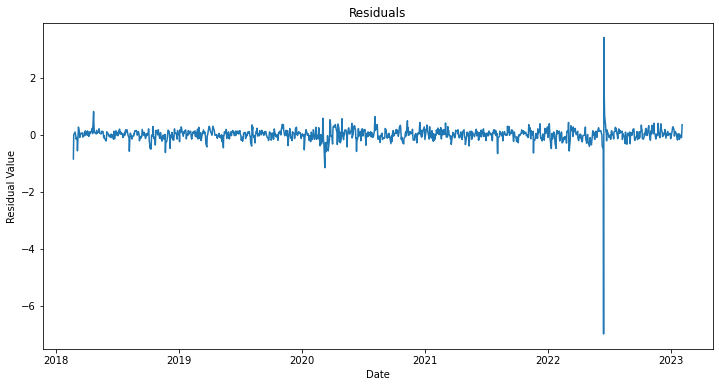

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2886.466, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2885.147, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2885.054, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2887.252, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2885.881, Time=1.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.064 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  GRG.L   No. Observations:                 1249
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1444.626
Date:                Sat, 21 Oct 2023   AIC                          -2887.252
Time:                        14:18:19   BIC                          -2882.122
Sample:                             0   HQIC                         -2885.323
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0058      0.000     54.197      0.000       0.006       0.006
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):              2858.75
Prob(Q):                              0.41   Pr

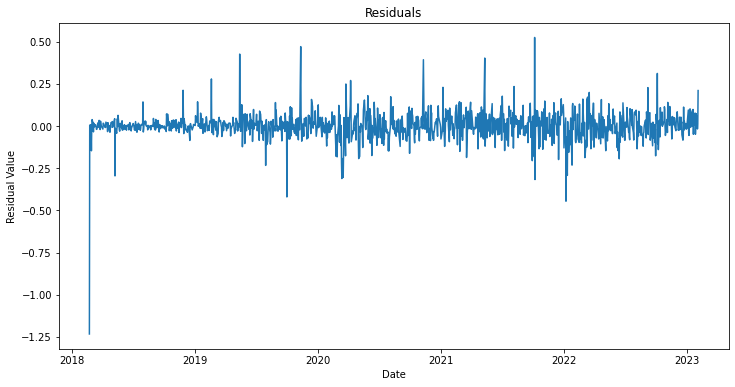

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1923.346, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1922.698, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1922.502, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1925.346, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1934.033, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1934.944, Time=1.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1929.776, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1933.194, Time=2.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1933.093, Time=1.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1934.840, Time=1.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1930.254, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1931.275, Time=2.93 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1936.944, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1936.396, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VTY.L   No. Observations:                 1249
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 972.472
Date:                Sat, 21 Oct 2023   AIC                          -1936.944
Time:                        14:18:39   BIC                          -1916.427
Sample:                             0   HQIC                         -1929.230
                               - 1249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7658      0.086      8.926      0.000       0.598       0.934
ar.L2          0.0523      0.026      2.033      0.042       0.002       0.103
ma.L1         -0.7451      0.082     -9.063      0.0

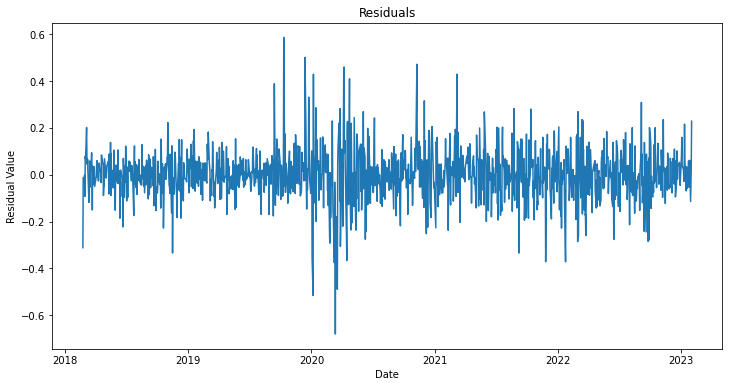

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [16]:
dict_df_T = dict_df.T
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction
BDEV.L,0.0,0.0,1.0,-0.169960
EDV.L,1.0,1.0,1.0,-0.424307
ABDN.L,0.0,0.0,1.0,-0.073034
BLND.L,0.0,0.0,1.0,0.230458
JMAT.L,0.0,0.0,1.0,-0.295943
HSX.L,0.0,0.0,1.0,0.116820
UTG.L,1.0,0.0,1.0,0.788979
FRAS.L,0.0,0.0,1.0,1.774805
CCL.L,0.0,0.0,1.0,-1.013933
INVP.L,0.0,0.0,1.0,2.425980


In [17]:
###############################


#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-8])
dict_df_T["naive_prediction"] = naive_predictions


In [18]:
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BDEV.L,0.0,0.0,1.0,-0.169960,-0.360010
EDV.L,1.0,1.0,1.0,-0.424307,-0.430270
ABDN.L,0.0,0.0,1.0,-0.073034,-0.231555
BLND.L,0.0,0.0,1.0,0.230458,-0.236114
JMAT.L,0.0,0.0,1.0,-0.295943,-0.735393
HSX.L,0.0,0.0,1.0,0.116820,0.147446
UTG.L,1.0,0.0,1.0,0.788979,0.465102
FRAS.L,0.0,0.0,1.0,1.774805,1.600769
CCL.L,0.0,0.0,1.0,-1.013933,-1.082719
INVP.L,0.0,0.0,1.0,2.425980,2.342837


In [19]:
#verifying that the naive prediction is identical with the actual price.iloc[-8]

df_standardised.iloc[-8] == dict_df_T["naive_prediction"]

Ticker_Symbol
BDEV.L    True
EDV.L     True
ABDN.L    True
BLND.L    True
JMAT.L    True
HSX.L     True
UTG.L     True
FRAS.L    True
CCL.L     True
INVP.L    True
ICP.L     True
IMI.L     True
HWDN.L    True
HIK.L     True
INCH.L    True
EZJ.L     True
DPH.L     True
ITV.L     True
DPLM.L    True
IGG.L     True
SXS.L     True
TATE.L    True
EMG.L     True
TUI.L     True
GAW.L     True
MKS.L     True
DLN.L     True
RSW.L     True
BBOX.L    True
ROR.L     True
GRG.L     True
VTY.L     True
dtype: bool

In [20]:
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

BDEV.L    False
EDV.L     False
ABDN.L    False
BLND.L    False
JMAT.L    False
HSX.L     False
UTG.L     False
FRAS.L    False
CCL.L     False
INVP.L    False
ICP.L     False
IMI.L     False
HWDN.L    False
HIK.L     False
INCH.L    False
EZJ.L     False
DPH.L     False
ITV.L     False
DPLM.L    False
IGG.L     False
SXS.L     False
TATE.L    False
EMG.L     False
TUI.L     False
GAW.L     False
MKS.L     False
DLN.L     False
RSW.L     False
BBOX.L    False
ROR.L     False
GRG.L     False
VTY.L     False
dtype: bool

In [21]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

False    32
Name: count, dtype: int64

In [22]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BDEV.L,0.0,0.0,1.0,-0.169960,-0.360010
EDV.L,1.0,1.0,1.0,-0.424307,-0.430270
ABDN.L,0.0,0.0,1.0,-0.073034,-0.231555
BLND.L,0.0,0.0,1.0,0.230458,-0.236114
JMAT.L,0.0,0.0,1.0,-0.295943,-0.735393
HSX.L,0.0,0.0,1.0,0.116820,0.147446
UTG.L,1.0,0.0,1.0,0.788979,0.465102
FRAS.L,0.0,0.0,1.0,1.774805,1.600769
CCL.L,0.0,0.0,1.0,-1.013933,-1.082719
INVP.L,0.0,0.0,1.0,2.425980,2.342837


In [23]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [24]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

comparision_df["Actual Price, y"] =\
(
        actual_price_df.loc[comparision_df.index].values
)


In [25]:
comparision_df

,ARIMA_prediction,naive_prediction
BDEV.L,-0.169960,-0.360010
EDV.L,-0.424307,-0.430270
ABDN.L,-0.073034,-0.231555
BLND.L,0.230458,-0.236114
JMAT.L,-0.295943,-0.735393
HSX.L,0.116820,0.147446
UTG.L,0.788979,0.465102
FRAS.L,1.774805,1.600769
CCL.L,-1.013933,-1.082719
INVP.L,2.425980,2.342837


In [26]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y"
BDEV.L,-0.169960,-0.360010,-0.379875
EDV.L,-0.424307,-0.430270,-0.825824
ABDN.L,-0.073034,-0.231555,-0.202352
BLND.L,0.230458,-0.236114,-0.161147
JMAT.L,-0.295943,-0.735393,-0.716008
HSX.L,0.116820,0.147446,0.190444
UTG.L,0.788979,0.465102,0.274519
FRAS.L,1.774805,1.600769,1.757952
CCL.L,-1.013933,-1.082719,-1.055180
INVP.L,2.425980,2.342837,2.270363


In [27]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BDEV.L,-0.169960,-0.360010,-0.379875,0.044064,0.000395
EDV.L,-0.424307,-0.430270,-0.825824,0.161216,0.156463
ABDN.L,-0.073034,-0.231555,-0.202352,0.016723,0.000853
BLND.L,0.230458,-0.236114,-0.161147,0.153355,0.005620
JMAT.L,-0.295943,-0.735393,-0.716008,0.176455,0.000376
HSX.L,0.116820,0.147446,0.190444,0.005421,0.001849
UTG.L,0.788979,0.465102,0.274519,0.264669,0.036322
FRAS.L,1.774805,1.600769,1.757952,0.000284,0.024706
CCL.L,-1.013933,-1.082719,-1.055180,0.001701,0.000758
INVP.L,2.425980,2.342837,2.270363,0.024217,0.005253


In [28]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y"
BDEV.L,0.0,0.0,1.0,-0.169960,-0.360010,-0.379875
EDV.L,1.0,1.0,1.0,-0.424307,-0.430270,-0.825824
ABDN.L,0.0,0.0,1.0,-0.073034,-0.231555,-0.202352
BLND.L,0.0,0.0,1.0,0.230458,-0.236114,-0.161147
JMAT.L,0.0,0.0,1.0,-0.295943,-0.735393,-0.716008
HSX.L,0.0,0.0,1.0,0.116820,0.147446,0.190444
UTG.L,1.0,0.0,1.0,0.788979,0.465102,0.274519
FRAS.L,0.0,0.0,1.0,1.774805,1.600769,1.757952
CCL.L,0.0,0.0,1.0,-1.013933,-1.082719,-1.055180
INVP.L,0.0,0.0,1.0,2.425980,2.342837,2.270363


In [29]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BDEV.L,0.0,0.0,1.0,-0.169960,-0.360010,-0.379875,0.044064,0.000395
EDV.L,1.0,1.0,1.0,-0.424307,-0.430270,-0.825824,0.161216,0.156463
ABDN.L,0.0,0.0,1.0,-0.073034,-0.231555,-0.202352,0.016723,0.000853
BLND.L,0.0,0.0,1.0,0.230458,-0.236114,-0.161147,0.153355,0.005620
JMAT.L,0.0,0.0,1.0,-0.295943,-0.735393,-0.716008,0.176455,0.000376
HSX.L,0.0,0.0,1.0,0.116820,0.147446,0.190444,0.005421,0.001849
UTG.L,1.0,0.0,1.0,0.788979,0.465102,0.274519,0.264669,0.036322
FRAS.L,0.0,0.0,1.0,1.774805,1.600769,1.757952,0.000284,0.024706
CCL.L,0.0,0.0,1.0,-1.013933,-1.082719,-1.055180,0.001701,0.000758
INVP.L,0.0,0.0,1.0,2.425980,2.342837,2.270363,0.024217,0.005253


In [30]:
dict_df_T[dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]]

#observation: if p = 0 and q = 0, ARIMA_prediction = naive_prediction

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive


In [31]:
dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BDEV.L,0.0,0.0,1.0,-0.169960,-0.360010,-0.379875,0.044064,0.000395
EDV.L,1.0,1.0,1.0,-0.424307,-0.430270,-0.825824,0.161216,0.156463
ABDN.L,0.0,0.0,1.0,-0.073034,-0.231555,-0.202352,0.016723,0.000853
BLND.L,0.0,0.0,1.0,0.230458,-0.236114,-0.161147,0.153355,0.005620
JMAT.L,0.0,0.0,1.0,-0.295943,-0.735393,-0.716008,0.176455,0.000376
HSX.L,0.0,0.0,1.0,0.116820,0.147446,0.190444,0.005421,0.001849
UTG.L,1.0,0.0,1.0,0.788979,0.465102,0.274519,0.264669,0.036322
FRAS.L,0.0,0.0,1.0,1.774805,1.600769,1.757952,0.000284,0.024706
CCL.L,0.0,0.0,1.0,-1.013933,-1.082719,-1.055180,0.001701,0.000758
INVP.L,0.0,0.0,1.0,2.425980,2.342837,2.270363,0.024217,0.005253


In [32]:
#confusion matrix

#define positive, with reference to the rank of the 35 stocks at balancing date.
#need to multiply the actual price(un-normalised) * number of outstanding share
#postive result is reflected as 1 when the market cap of the 35 stocks are above the lowest of the 100th market cap. 

#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_price"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_price", "un-normalised_ARIMA_pred", "un-normalised_naive_pred"]].mul(symbols_["Shares"].loc[dict_df_T.index], axis=0)
result


,un-normalised_actual_price,un-normalised_ARIMA_pred,un-normalised_naive_pred
BDEV.L,4.296269e+05,4.481987e+05,4.313844e+05
EDV.L,3.006471e+05,3.338000e+05,3.333077e+05
ABDN.L,4.013415e+05,4.106755e+05,3.992336e+05
BLND.L,3.985547e+05,4.209040e+05,3.942763e+05
JMAT.L,3.797519e+05,4.124724e+05,3.782419e+05
HSX.L,3.733857e+05,3.667347e+05,3.695014e+05
UTG.L,3.031361e+05,3.257226e+05,3.115033e+05
FRAS.L,1.045280e+05,1.049392e+05,1.006924e+05
CCL.L,1.183602e+05,1.264212e+05,1.129779e+05
INVP.L,3.353925e+05,3.455553e+05,3.401256e+05


In [33]:
result["un-normalised_actual_price"].sort_values(ascending=False)
result["un-normalised_ARIMA_pred"].sort_values(ascending=False)
result["un-normalised_naive_pred"].sort_values(ascending=False)

TUI.L     2.148921e+06
BDEV.L    4.313844e+05
ABDN.L    3.992336e+05
BLND.L    3.942763e+05
ICP.L     3.826809e+05
JMAT.L    3.782419e+05
IMI.L     3.696418e+05
HSX.L     3.695014e+05
HWDN.L    3.534598e+05
INVP.L    3.401256e+05
EDV.L     3.333077e+05
INCH.L    3.332928e+05
SXS.L     3.311363e+05
DPLM.L    3.300374e+05
EZJ.L     3.222396e+05
UTG.L     3.115033e+05
DPH.L     3.101045e+05
EMG.L     2.980820e+05
TATE.L    2.979511e+05
GAW.L     2.968531e+05
ITV.L     2.889039e+05
IGG.L     2.880810e+05
MKS.L     2.860948e+05
BBOX.L    2.836352e+05
DLN.L     2.796876e+05
ROR.L     2.698079e+05
HIK.L     2.648357e+05
GRG.L     2.638323e+05
VTY.L     2.394152e+05
RSW.L     1.312496e+05
CCL.L     1.129779e+05
FRAS.L    1.006924e+05
Name: un-normalised_naive_pred, dtype: float64

In [34]:
result["un-normalised_actual_price"].sort_values(ascending=False)
actual = result["un-normalised_actual_price"].sort_values(ascending=False)
actual_tidied = actual.reset_index().rename(columns = {"index" : "Ticker"})
actual_tidied[["Ticker"]]

,Ticker
0,TUI.L
1,BDEV.L
2,ABDN.L
3,BLND.L
4,IMI.L
5,JMAT.L
6,ICP.L
7,HSX.L
8,HWDN.L
9,SXS.L


In [35]:
result["un-normalised_ARIMA_pred"].sort_values(ascending=False)
ARIMA = result["un-normalised_ARIMA_pred"].sort_values(ascending=False)
ARIMA_tidied = ARIMA.reset_index().rename(columns = {"index" : "Ticker"})
ARIMA_tidied[["Ticker"]]

,Ticker
0,TUI.L
1,BDEV.L
2,BLND.L
3,JMAT.L
4,ABDN.L
5,ICP.L
6,IMI.L
7,HWDN.L
8,HSX.L
9,DPLM.L


In [36]:
result["un-normalised_naive_pred"].sort_values(ascending=False)
naive = result["un-normalised_naive_pred"].sort_values(ascending=False)
naive_tidied = naive.reset_index().rename(columns = {"index" : "Ticker"})
naive_tidied[["Ticker"]]

,Ticker
0,TUI.L
1,BDEV.L
2,ABDN.L
3,BLND.L
4,ICP.L
5,JMAT.L
6,IMI.L
7,HSX.L
8,HWDN.L
9,INVP.L


In [40]:
######
#change in FTSE100 (focusing on exit)

#being NOT included in ftse100 is positive result 
def is_excluded_FTSE100(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    top_10_rank = model_df.loc[:10]
    
    true_count = 0
    #false_count = 0
    
    for rank in top_10_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if not actual_tidied.loc[:10].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_positive = true_count / len(actual_tidied)
    false_positive = (10 - true_count) / len(actual_tidied)
    
    return true_positive, false_positive

#being included in ftse100 is negative result 
def is_included_FTSE100(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    top_10_rank = model_df.loc[:10]
    
    true_count = 0
    #false_count = 0
    
    for rank in top_10_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if actual_tidied.loc[:10].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_negative = true_count / len(actual_tidied) #stated to be included in top 10 and it is in top 10
    false_negative = (10 - true_count) / len(actual_tidied) #stated to be included but not included in top 10
    
    return true_negative, false_negative

In [41]:
######
#change in FTSE250 (focusing on enter)

#being included in ftse250 is positive result 
def is_included_FTSE250(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    bottom_25_rank = model_df.loc[10:]
    
    true_count = 0
    #false_count = 0
    
    for rank in bottom_25_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if actual_tidied.loc[10:].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_positive = true_count / len(actual_tidied)
    false_positive = (len(actual_tidied.iloc[10:]) - true_count) / len(actual_tidied)
    
    return true_positive, false_positive

#being excluded in ftse250 is negative result 
def is_excluded_FTSE250(actual_tidied, model_df):
    #referring to the model ordered market cap
    #top_10_rank = actual_tidied.loc[:10]
    bottom_25_rank = model_df.loc[10:]
    
    true_count = 0
    #false_count = 0
    
    for rank in bottom_25_rank:
        #if model_df.loc[:10].isin([rank]).any():
        if actual_tidied.loc[10:].isin([rank]).any():
            true_count += 1
        #else: 
            #false_count += 1
            
    true_negative = true_count / len(actual_tidied) #stated to be included in top 10 and it is in top 10
    false_negative = (len(actual_tidied.iloc[10:]) - true_count) / len(actual_tidied) #stated to be included but not included in top 10
    
    return true_negative, false_negative

In [42]:
true_positive_naive_FTSE100, false_positive_naive_FTSE100 = is_excluded_FTSE100(actual_tidied["Ticker"], naive_tidied["Ticker"])
true_negative_naive_FTSE100, false_negative_naive_FTSE100 = is_included_FTSE100(actual_tidied["Ticker"], naive_tidied["Ticker"])

true_negative_naive_FTSE250, false_negative_naive_FTSE250 = is_excluded_FTSE250(actual_tidied["Ticker"], naive_tidied["Ticker"])
true_postive_naive_FTSE250, false_positive_naive_FTSE250 = is_included_FTSE250(actual_tidied["Ticker"], naive_tidied["Ticker"])

In [43]:
true_positive_ARIMA_FTSE100, false_positive_ARIMA_FTSE100 = is_excluded_FTSE100(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])
true_negative_ARIMA_FTSE100, false_negative_ARIMA_FTSE100 = is_included_FTSE100(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])

true_negative_ARIMA_FTSE250, false_negative_ARIMA_FTSE250 = is_excluded_FTSE250(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])
true_postive_ARIMA_FTSE250, false_positive_ARIMA_FTSE250 = is_included_FTSE250(actual_tidied["Ticker"], ARIMA_tidied["Ticker"])

In [44]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive_FTSE100*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive_FTSE100*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive_FTSE100*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive_FTSE100*100))

Percentage of true positive in naive model is 6.250%
Percentage of true negative in naive model is 28.125%
Percentage of false positive in naive model is 25.000%
Percentage of false negative in naive model is 3.125%


In [45]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA_FTSE100*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA_FTSE100*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA_FTSE100*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA_FTSE100*100))

Percentage of true positive in ARIMA model is 3.125%
Percentage of true negative in ARIMA model is 31.250%
Percentage of false positive in ARIMA model is 28.125%
Percentage of false negative in ARIMA model is 0.000%


In [37]:
actual_tidied[["Ticker"]] == naive_tidied[["Ticker"]]

,Ticker
0,True
1,True
2,True
3,True
4,False
5,True
6,False
7,True
8,True
9,False


In [38]:
actual_tidied[["Ticker"]] == ARIMA_tidied[["Ticker"]]

,Ticker
0,True
1,True
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


In [39]:
naive_tidied[["Ticker"]] == ARIMA_tidied[["Ticker"]]

,Ticker
0,True
1,True
2,False
3,False
4,False
5,False
6,True
7,False
8,False
9,False
